In [1]:
# モジュールのインポート
import pandas as pd
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import functional
import segmentation_models_pytorch as smp
import random

In [2]:
from glob import glob
import os
import shutil
import math

In [3]:
df = pd.read_csv("./data/train.csv")
df.head(100)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
95,case123_day20_slice_0032,stomach,NaN
96,case123_day20_slice_0033,large_bowel,NaN
97,case123_day20_slice_0033,small_bowel,NaN
98,case123_day20_slice_0033,stomach,NaN


In [4]:
df2 = df.dropna()
df2

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...
...,...,...,...
115459,case30_day0_slice_0135,small_bowel,22540 1 22804 5 23069 7 23334 10 23600 11 2386...
115461,case30_day0_slice_0136,large_bowel,18746 7 19009 23 19038 7 19273 44 19537 49 198...
115462,case30_day0_slice_0136,small_bowel,23079 1 23343 6 23608 9 23874 11 24139 13 2440...
115464,case30_day0_slice_0137,large_bowel,18746 2 19010 8 19040 3 19274 25 19302 12 1953...


In [5]:
# 各情報を含むdataframeを作成する
id_list = df.id
imgpath_list = []
height_list = []
width_list = []
hpix_list = []
wpix_list = []
for i in range(len(df)):
    id = id_list[i]
    split__id = id.split("_")
    imgpath = glob("./data/train/" + split__id[0] + "/" + split__id[0] + "_" + split__id[1] + "/scans/" + split__id[2] + "_" + split__id[3] + "_*.png")[0]
    basename = os.path.basename(imgpath)
    height = basename.split("_")[2]
    width = basename.split("_")[3]
    hpix = basename.split("_")[4]
    wpix = basename.split("_")[5].split(".png")[0]
    imgpath_list.append(imgpath)
    height_list.append(height)
    width_list.append(width)
    hpix_list.append(hpix)
    wpix_list.append(wpix)

df["case_day"] = [i[:-11] for i in df.id]
df["imgpath"] = imgpath_list
df["height"] = height_list
df["width"] = width_list
df["hpix"] = hpix_list
df["wpix"] = wpix_list

In [6]:
df

,id,class,segmentation,case_day,imgpath,height,width,hpix,wpix
0,case123_day20_slice_0001,large_bowel,NaN,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50
1,case123_day20_slice_0001,small_bowel,NaN,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50
2,case123_day20_slice_0001,stomach,NaN,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50
3,case123_day20_slice_0002,large_bowel,NaN,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50
4,case123_day20_slice_0002,small_bowel,NaN,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50
...,...,...,...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.50,1.50
115484,case30_day0_slice_0143,stomach,NaN,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.50,1.50
115485,case30_day0_slice_0144,large_bowel,NaN,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.50,1.50
115486,case30_day0_slice_0144,small_bowel,NaN,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.50,1.50


In [7]:
df.id.unique()

array(['case123_day20_slice_0001', 'case123_day20_slice_0002',
       'case123_day20_slice_0003', ..., 'case30_day0_slice_0142',
       'case30_day0_slice_0143', 'case30_day0_slice_0144'], dtype=object)

In [9]:
# train.csvのsegmentation情報をpngファイルとして保存している
# インデックスカラーとして保存しており、large_bowelのピクセルを1、small_bowelのピクセルを2、stomachのピクセルを3としている

labelpath_list = []
n_list = []
for i, img_id in enumerate(df['id'].unique()):
    n = 0
    img_data = df[df['id'] == img_id]
    height = int(img_data['height'].iloc[0])
    width = int(img_data['width'].iloc[0])
    label = np.zeros((height * width), dtype='uint8')

    org_list = ["large_bowel", "small_bowel", "stomach"]
    segmentation_list = []

    # 各臓器のセグメンテーション情報を処理
    for j, org in enumerate(org_list, start=1):
        org_data = img_data[img_data['class'] == org]
        segmentation_str = org_data['segmentation'].iloc[0]
        if isinstance(segmentation_str, str):
            # セグメンテーション情報が存在する場合
            segmentations = [int(x) for x in segmentation_str.split(" ")]
            segmentations = [[x,y] for x, y in zip(segmentations[::2], segmentations[1::2])]
            n = 1 # 何かのラベルがあれば１
        else:
            segmentations = []
        segmentation_list.append((segmentations, j)) # セグメンテーション情報とカラーコードを保存

    # セグメンテーション情報を元に画像に色を付ける
    for segmentations, color_code in segmentation_list:
        for start, end in segmentations:
            label[start:end] = np.array(color_code, dtype='uint8')

    # ラベルの形状を整え、Imageオブジェクトとして保存
    label = np.reshape(label, (width, height))
    label = Image.fromarray(label, mode = "P")

    # 保存ディレクトリの作成
    img_dir = os.path.dirname(img_data['imgpath'].iloc[0])[:-5] # 画像のディレクトリ
    label_dir = os.path.join(img_dir, "label")
    os.makedirs(label_dir, exist_ok=True)
    
    # ラベル画像の保存パス
    label_path = os.path.join(label_dir, f"{img_id}_label.png")
    label.save(label_path)

    # 保存したラベル画像のパスとラベルの存在有無をリストに追加
    labelpath_list.append(label_path)
    n_list.append(n)

In [10]:
# 上記のコードで作成したラベルに関する情報をdataframeに追加する
df = df.drop(["class", "segmentation"], axis=1)
df = df[1::3]
df = df.reset_index(drop=True)
df["labelpath"] = labelpath_list
df["label"] = n_list # labelカラムはラベル無しの場合は0、ラベル有りの場合は1となる

In [10]:
df

,id,case_day,imgpath,height,width,hpix,wpix,labelpath,label
0,case123_day20_slice_0001,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50,./data/train/case123/case123_day20/label/case1...,0
1,case123_day20_slice_0002,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50,./data/train/case123/case123_day20/label/case1...,0
2,case123_day20_slice_0003,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50,./data/train/case123/case123_day20/label/case1...,0
3,case123_day20_slice_0004,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50,./data/train/case123/case123_day20/label/case1...,0
4,case123_day20_slice_0005,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50,./data/train/case123/case123_day20/label/case1...,0
...,...,...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.50,1.50,./data/train/case30/case30_day0/label/case30_d...,0
38492,case30_day0_slice_0141,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.50,1.50,./data/train/case30/case30_day0/label/case30_d...,0
38493,case30_day0_slice_0142,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.50,1.50,./data/train/case30/case30_day0/label/case30_d...,0
38494,case30_day0_slice_0143,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.50,1.50,./data/train/case30/case30_day0/label/case30_d...,0


In [11]:
df

,id,case_day,imgpath,height,width,hpix,wpix,labelpath,label
0,case123_day20_slice_0001,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50,./data/train/case123/case123_day20/label/case1...,0
1,case123_day20_slice_0002,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50,./data/train/case123/case123_day20/label/case1...,0
2,case123_day20_slice_0003,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50,./data/train/case123/case123_day20/label/case1...,0
3,case123_day20_slice_0004,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50,./data/train/case123/case123_day20/label/case1...,0
4,case123_day20_slice_0005,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.50,1.50,./data/train/case123/case123_day20/label/case1...,0
...,...,...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.50,1.50,./data/train/case30/case30_day0/label/case30_d...,0
38492,case30_day0_slice_0141,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.50,1.50,./data/train/case30/case30_day0/label/case30_d...,0
38493,case30_day0_slice_0142,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.50,1.50,./data/train/case30/case30_day0/label/case30_d...,0
38494,case30_day0_slice_0143,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.50,1.50,./data/train/case30/case30_day0/label/case30_d...,0


In [12]:
df.to_csv("./data/moddf.csv")

(array([21906.,     0., 16590.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

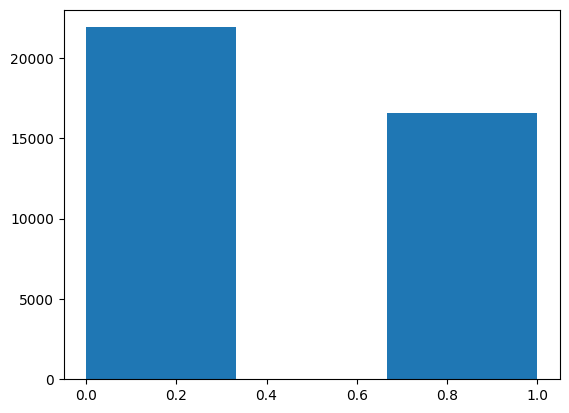

In [13]:
# ラベル有りの比率を描写
plt.hist(df.label, bins=3)

In [14]:
# データの再読み込み
df = pd.read_csv("./data/moddf.csv")

In [15]:
df

,Unnamed: 0,id,case_day,imgpath,height,width,hpix,wpix,labelpath,label
0,0,case123_day20_slice_0001,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.5,1.5,./data/train/case123/case123_day20/label/case1...,0
1,1,case123_day20_slice_0002,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.5,1.5,./data/train/case123/case123_day20/label/case1...,0
2,2,case123_day20_slice_0003,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.5,1.5,./data/train/case123/case123_day20/label/case1...,0
3,3,case123_day20_slice_0004,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.5,1.5,./data/train/case123/case123_day20/label/case1...,0
4,4,case123_day20_slice_0005,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.5,1.5,./data/train/case123/case123_day20/label/case1...,0
...,...,...,...,...,...,...,...,...,...,...
38491,38491,case30_day0_slice_0140,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.5,1.5,./data/train/case30/case30_day0/label/case30_d...,0
38492,38492,case30_day0_slice_0141,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.5,1.5,./data/train/case30/case30_day0/label/case30_d...,0
38493,38493,case30_day0_slice_0142,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.5,1.5,./data/train/case30/case30_day0/label/case30_d...,0
38494,38494,case30_day0_slice_0143,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.5,1.5,./data/train/case30/case30_day0/label/case30_d...,0


In [16]:
# データをcase_dayごとに学習、検証、テストデータに分割
caseday_set = set(df.case_day)
train_list = random.sample(caseday_set, 250) #学習データは250case_day

valtest_list = caseday_set ^ set(train_list)
val_list = random.sample(valtest_list, 20) #学習データは20case_day

test_list = valtest_list ^ set(val_list) #学習データは4case_day
print(len(caseday_set))
print(len(train_list), len(val_list), len(test_list))

274
250 20 4


/var/folders/4s/9dr7h7357q76x7wn5wg6mlww0000gn/T/ipykernel_41373/4050589571.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_list = random.sample(caseday_set, 250) #学習データは250case_day
/var/folders/4s/9dr7h7357q76x7wn5wg6mlww0000gn/T/ipykernel_41373/4050589571.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  val_list = random.sample(valtest_list, 20) #学習データは20case_day


In [17]:
#データフレームを、学習、検証、テストデータのcase_dayで分割します。
train_df = df[df.case_day.apply(lambda x: x in train_list)]
val_df = df[df.case_day.apply(lambda x: x in val_list)]
test_df = df[df.case_day.apply(lambda x: x in test_list)]

print(len(train_df), len(val_df), len(test_df))

train_df.to_csv("./data/train_df.csv")
val_df.to_csv("./data/val_df.csv")
test_df.to_csv("./data/test_df.csv")

35104 2816 576


In [18]:
#再読み込みしています。
train_df = pd.read_csv("./data/train_df.csv")
val_df = pd.read_csv("./data/val_df.csv")
test_df = pd.read_csv("./data/test_df.csv")

In [19]:
train_df

,Unnamed: 0.1,Unnamed: 0,id,case_day,imgpath,height,width,hpix,wpix,labelpath,label
0,0,0,case123_day20_slice_0001,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.5,1.5,./data/train/case123/case123_day20/label/case1...,0
1,1,1,case123_day20_slice_0002,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.5,1.5,./data/train/case123/case123_day20/label/case1...,0
2,2,2,case123_day20_slice_0003,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.5,1.5,./data/train/case123/case123_day20/label/case1...,0
3,3,3,case123_day20_slice_0004,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.5,1.5,./data/train/case123/case123_day20/label/case1...,0
4,4,4,case123_day20_slice_0005,case123_day20,./data/train/case123/case123_day20/scans/slice...,266,266,1.5,1.5,./data/train/case123/case123_day20/label/case1...,0
...,...,...,...,...,...,...,...,...,...,...,...
35099,38491,38491,case30_day0_slice_0140,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.5,1.5,./data/train/case30/case30_day0/label/case30_d...,0
35100,38492,38492,case30_day0_slice_0141,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.5,1.5,./data/train/case30/case30_day0/label/case30_d...,0
35101,38493,38493,case30_day0_slice_0142,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.5,1.5,./data/train/case30/case30_day0/label/case30_d...,0
35102,38494,38494,case30_day0_slice_0143,case30_day0,./data/train/case30/case30_day0/scans/slice_01...,266,266,1.5,1.5,./data/train/case30/case30_day0/label/case30_d...,0


In [21]:
#本データセットは深さ80と144のデータが混じっています。8で分割する分には以下のコードで問題ございませんが、3DUNetを構築する場合は深さ80と144により処理を分ける必要があります。
def make_3Ddataframe(df,dim):
  caseday_list = []
  id_list = []
  imgpath_list = [[] for i in range(dim)]
  labelpath_list = [[] for i in range(dim)]
  height_list = []
  width_list = []
  label_list = []
  for i in range(len(df)):
    if i % dim == 0:
      caseday_list.append(df.iloc[i,:].case_day)
      height_list.append(df.iloc[i,:].height)
      width_list.append(df.iloc[i,:].width)
      id_list.append(df.iloc[i,:].id + "_" + df.iloc[i + dim - 1,:].id)
      label_list.append(df.iloc[i:i + dim,:].label.sum())
      label_list = [1 if i != 0 else 0 for i in label_list]
      for j in range(dim):
        imgpath_list[j].append(df.iloc[i+j,:].imgpath)
        labelpath_list[j].append(df.iloc[i+j,:].labelpath)

  df = pd.DataFrame(id_list, columns =  ["id"])
  df["caseday"] = caseday_list
  for i in range(dim):
    df[f"imgpath_{i}"] = imgpath_list[i]
  for i in range(dim):
    df[f"labelpath_{i}"] = labelpath_list[i]
  df["height"] = height_list
  df["width"] = width_list
  df["label"] = label_list
  return df

In [22]:
train_3D8_df = make_3Ddataframe(train_df, 8)
val_3D8_df = make_3Ddataframe(val_df, 8)
test_3D8_df = make_3Ddataframe(test_df, 8)

In [23]:
train_3D8_df

,id,caseday,imgpath_0,imgpath_1,imgpath_2,imgpath_3,imgpath_4,imgpath_5,imgpath_6,imgpath_7,...,labelpath_1,labelpath_2,labelpath_3,labelpath_4,labelpath_5,labelpath_6,labelpath_7,height,width,label
0,case123_day20_slice_0001_case123_day20_slice_0008,case123_day20,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,266,266,0
1,case123_day20_slice_0009_case123_day20_slice_0016,case123_day20,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,266,266,0
2,case123_day20_slice_0017_case123_day20_slice_0024,case123_day20,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,266,266,0
3,case123_day20_slice_0025_case123_day20_slice_0032,case123_day20,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,./data/train/case123/case123_day20/label/case1...,266,266,0
4,case123_day20_slice_0033_case123_day20_slice_0040,case123_day20,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,./data/train/case123/case123_day20/scans/slice...,...,./data/trai

In [24]:
train_3D8_df.to_csv("./data/train_3D8_df.csv")
val_3D8_df.to_csv("./data/val_3D8_df.csv")
test_3D8_df.to_csv("./data/test_3D8_df.csv")

In [ ]:
train_df = train_3D8_df[train_3D8_df.label == 1].reset_index(drop=True) # ラベル有りのデータのみ抽出
val_df = val_3D8_df[val_3D8_df.label == 1].reset_index(drop=True) # ラベル有りのデータのみ抽出
test_df = test_3D8_df[test_3D8_df.label == 1].reset_index(drop=True) # ラベル有りのデータのみ抽出

print(train_df.shape)
print(train_df.columns)